# Daedalus: Autoencoder and GAN

## setup

In [1]:
from collections import deque
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## helpers

### maze generator

In [2]:
# hyperparameters
MOVES = [
    (-1, 0), # up
    (1, 0),  # down
    (0, -1), # left
    (0, 1),  # right
]

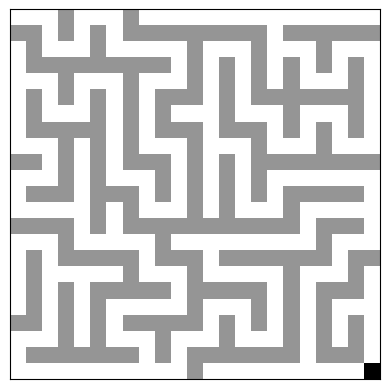

In [3]:
# maze generator
def make_maze(width):
    maze = torch.zeros((width, width))
    def add_exit(maze):
        choices = (maze == 1).nonzero().tolist()
        furthest = max(choices, key=lambda x: x[0] + x[1])
        maze[furthest[0], furthest[1]] = -1

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 1, 1
            rec(nnx, nny)

    maze[0, 0] = 1
    rec(0, 0)
    add_exit(maze)
    return maze

def ascii_maze(maze):
    lookup = {0: '@', 1: '_', -1: 'x'}
    print('\n'.join(''.join(lookup[i] for i in row) for row in maze.tolist()))

def plot_maze(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(-maze, 'Greys')
    ax.set_xticks([])
    ax.set_yticks([])

# look at the maze
maze = make_maze(23)
plot_maze(maze)
# ascii_maze(maze)

In [4]:
# maze generator
def make_maze_steps(width):
    maze = torch.zeros((width, width))
    steps = []

    def rec(x, y):
        while True:
            pairs = []
            for move in MOVES:
                dx, dy = move
                nx, ny = x + dx, y + dy
                nnx, nny = nx + dx, ny + dy
                if 0 <= nnx < width and 0 <= nny < width and maze[nnx, nny] == 0 and maze[nx, ny] == 0:
                    pairs.append((nx, ny, nnx, nny))
            random.shuffle(pairs)
            if not pairs: break
            nx, ny, nnx, nny = pairs[0]
            maze[nx, ny], maze[nnx, nny] = 2, 2
            cp = copy.deepcopy(maze)
            cp[nx, ny], cp[nnx, nny] = 1, 1
            steps.append(cp)
            steps.append(copy.deepcopy(maze))
            rec(nnx, nny)

    maze[0, 0] = 2
    rec(0, 0)
    return steps

In [39]:
def get_frame(steps, ax):
    def f(d):
        ax.clear()
        ax.set_title(f'step {d // 2}')
        plot_maze(steps[d], ax=ax)
    return f

steps = make_maze_steps(23)
fig, ax = plt.subplots(figsize=(3, 3))
ani = FuncAnimation(fig, get_frame(steps, ax), frames=len(steps), interval=50, repeat=False)
plt.close()

display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-creation.gif', fps=20) # save to disk

### distances to exit

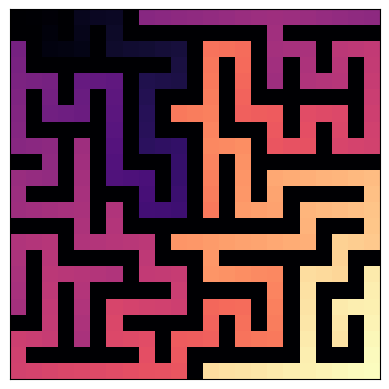

In [33]:
# compute optimal distances to the exit
def dists(maze):
    MAZE_WIDTH = maze.shape[0]
    pos = tuple((maze == -1).nonzero().tolist()[0]) # locate the exit
    dist = torch.zeros_like(maze)
    seen = set()
    q = deque()
    q.append((pos, 0))
    while q:
        pos, d = q.popleft()
        if pos in seen: continue
        if maze[pos] == 0: continue
        seen.add(pos)
        dist[pos] = d
        for move in MOVES:
            new_pos = (pos[0] + move[0], pos[1] + move[1])
            if 0 <= new_pos[0] < MAZE_WIDTH and 0 <= new_pos[1] < MAZE_WIDTH:
                q.append((new_pos, d + 1))
    return dist

def formatted_dists(maze):
    dist = dists(maze)
    unreachable = (dist == 0) & (maze == 1)
    # revert distances for plotting
    mask = maze != 0
    dist[mask] = dist.max() - dist[mask]
    # hide unreachable
    dist[unreachable] = torch.nan
    return dist

def plot_dists(maze, ax=None, figsize=None):
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    dist = formatted_dists(maze)
    ax.imshow(dist, cmap=plt.cm.magma, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

plot_dists(maze)

In [38]:
def get_frame(maze, ds, ax):
    def f(step):
        mz = copy.deepcopy(ds)
        mz[ds > step] = 0.
        mask = maze != 0
        mz[mask] = ds.max() - mz[mask]
        ax.clear()
        ax.set_title(f'step {step}')
        ax.imshow(mz, cmap=plt.cm.magma, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
    return f

def animate_dists(maze, figsize=(3, 3)):
    ds = dists(maze)
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(maze, ds, ax), frames=int(ds.max().item()) + 1, interval=50, repeat=False)
    plt.close()
    return ani

ani = animate_dists(maze)
display(HTML(ani.to_jshtml())) # display inline
ani.save('maze-dists.gif', fps=20) # save to disk

### plot

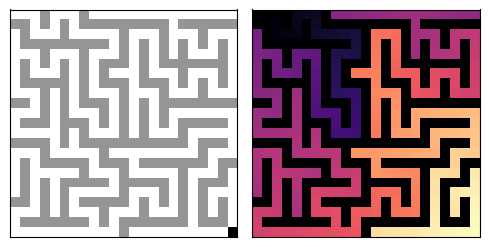

In [7]:
# plot maze and distances side by side
def plotm(maze, figsize=(5, 5)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    plot_maze(maze, ax=ax[0])
    plot_dists(maze, ax=ax[1])
    fig.tight_layout()

plotm(maze)

In [67]:
[batch][0].shape[0]

32

In [74]:
def plot(*args, n_col=None, figsize=None, block_size=3, dist=False):
    '''Plot the mazes in a grid
    usage: plot(maze1, maze2, ...)
    optional: n_col=3, figsize=(12, 8), block_size=1, dist=False

    maze: torch.Tensor of shape (H, W)
    '''
    mazes = args
    # unpack a batch into a list of mazes
    if len(mazes) == 1 and isinstance(mazes[0], torch.Tensor) and mazes[0].dim() == 4:
        mazes = [mazes[0][i] for i in range(mazes[0].shape[0])]
    # flatten channels
    mazes = [maze.squeeze(0) if maze.dim() == 3 else maze for maze in mazes]
    mazes = [maze.detach().cpu() for maze in mazes]

    if n_col is None: n_col = len(mazes)
    n_row = math.ceil(len(mazes) / n_col)
    if figsize is None: figsize = (n_col * block_size, n_row * block_size)
    if dist: mazes = [formatted_dists(m) for m in mazes]
    # normalize ax to 2d array
    fig, ax = plt.subplots(n_row, n_col, figsize=figsize)
    if n_row == 1 and n_col == 1: ax = np.array([[ax]])
    elif n_row == 1: ax = ax.reshape((1, -1))
    elif n_col == 1: ax = ax.reshape((-1, 1))
    # plot
    for i, maze in enumerate(mazes):
        idx = (i // n_col, i % n_col)
        if dist: ax[*idx].imshow(maze, cmap=plt.cm.magma, interpolation='nearest')
        else: ax[*idx].imshow(-maze, 'Greys')
    # remove the axis
    for i in range(n_row * n_col):
        idx = (i // n_col, i % n_col)
        ax[*idx].set_xticks([])
        ax[*idx].set_yticks([])
        if i >= len(mazes): ax[*idx].axis('off')
    plt.tight_layout()
    plt.show()

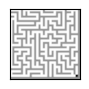

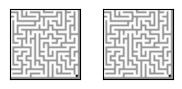

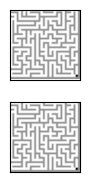

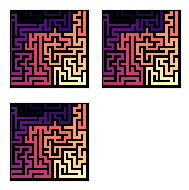

In [76]:
# test plot function
plot(maze, block_size=1)
plot(maze, maze, block_size=1)
plot(maze, maze, n_col=1, block_size=1)
plot(maze, maze, maze, n_col=2, block_size=1, dist=True)

## Autoencoder / VAE

### theory
- autoencoder: https://arxiv.org/pdf/2003.05991.pdf
- VAE: https://arxiv.org/pdf/1312.6114.pdf
- VQ-VAE: https://arxiv.org/pdf/1711.00937.pdf
- NVAE: https://arxiv.org/pdf/2007.03898.pdf

### setup

In [11]:
# hyperparameters
LEARNING_RATE = 3e-4

### model

In [91]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.nn_stack = nn.Sequential(
        # encoding
        nn.Conv2d(
            in_channels=1,
            out_channels=3,
            kernel_size=5,
            stride=1,
            padding='same',
        ),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(
            in_channels=3,
            out_channels=3,
            kernel_size=3,
            stride=2,
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=3,
            out_channels=6,
            kernel_size=3,
            stride=2,
        ),
        nn.ReLU(),
        # nn.MaxPool2d(kernel_size=2),
        # bottleneck lives here → ←
        nn.ConvTranspose2d(
            in_channels=6,
            out_channels=6,
            kernel_size=2,
            stride=2,
        ),
        nn.ReLU(),
        nn.ConvTranspose2d(
            in_channels=6,
            out_channels=3,
            kernel_size=5,
            stride=2,
        ),
        nn.ReLU(),
        nn.ConvTranspose2d(
            in_channels=3,
            out_channels=1,
            kernel_size=2,
            stride=1,
        ),
        nn.Sigmoid(),
    )
  def forward(self,x):
    return self.nn_stack(x)

m = Net()
maze = make_maze(32)
m(maze.view(1, 1, 32, 32)).shape

torch.Size([1, 6, 7, 7])

### train

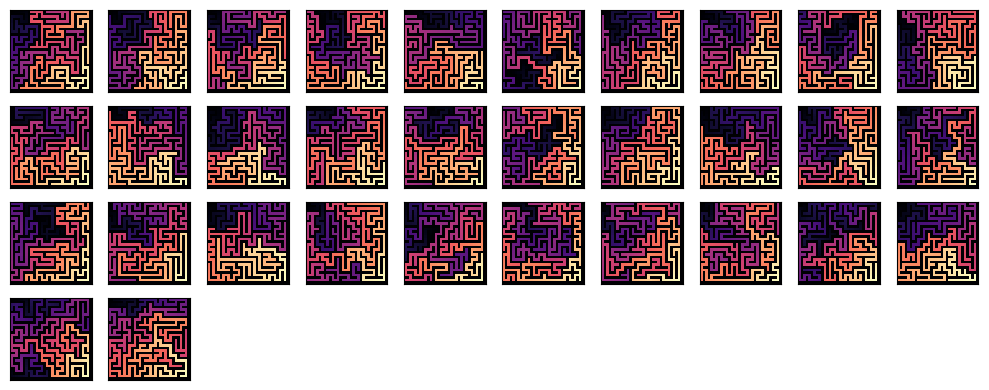

In [77]:
def get_batch(maze_size=32, batch_size=32):
    mazes = [make_maze(maze_size) for _ in range(batch_size)]
    return torch.stack(mazes).view(batch_size, 1, maze_size, maze_size)

batch = get_batch()
plot(batch, block_size=1, n_col=10, dist=True)

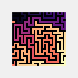

In [85]:
validation_batch = get_batch(batch_size=1)
plot(validation_batch, block_size=1, dist=True)

In [86]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

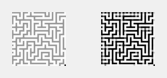

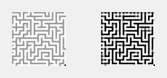

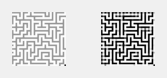

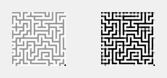

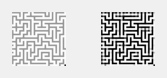

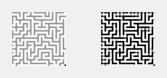

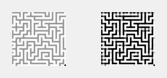

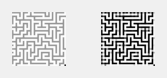

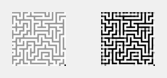

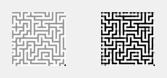

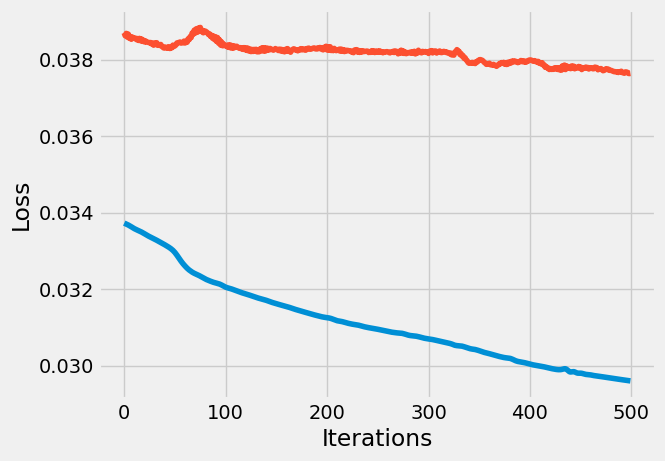

In [90]:
epochs = 500

outputs = []
losses = []
validation_losses = []

for epoch in range(epochs):
	maze_outputs = model(batch)
	loss = F.mse_loss(maze_outputs, batch)
	optimizer.zero_grad()
	loss.backward()
	optimizer.step()

	# Storing the losses in a list for plotting
	losses.append(loss)

	# Validation Loss
	with torch.no_grad():
		prediction = model(validation_batch)
		validation_loss = F.mse_loss(prediction, validation_batch)
		validation_losses.append(validation_loss)

	if epoch % 50 == 0:
		with torch.no_grad():
			one_maze = batch[0].view(32, 32)
			reconstructed_maze = model(one_maze.view(1, 1, 32, 32)).view(32, 32)
			plot(one_maze, reconstructed_maze, block_size=1)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot([l.detach() for l in losses])
plt.plot([l.detach() for l in validation_losses])

### exploitation

## GAN

### theory
https://arxiv.org/pdf/1406.2661.pdf

$\min_{G} \max_{D} V(D, G) = \mathbb{E}_{x\sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z\sim p_z(z)}[\log(1 - D(G(z)))].$

### setup

In [12]:
# hyperparameters
LEARNING_RATE = 3e-4

### generator

### discriminator

### train

### exploitation